# Neural Network using PyTorch

In this exercise, you will build a neural network using PyTorch, and apply it to a dataset. Our goal in this exercise is not necessarily to obtain the best results on the dataset. We care more about understanding the different parameters, getting a hands-on experience training networks, and monitoring and debugging them. For this reason, I actually recommend that you don’t use a GPU, and run the code on your local machine, for simpler debugging.


You can get relevant code snippets from [the PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or other sources online. 

## Dataset
We will use the CIFAR-10 dataset.

In [232]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import utils
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [ ]:
import random 
import numpy as np

FloatTensor = torch.FloatTensor
LongTensor =torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

if manualSeed is None:
    manualSeed = 42

fixSeed(manualSeed)

In [280]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print(f"CUDA is available! Training on {torch.cuda.get_device_name(0)}...")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Training on CPU...")
    device = 'cpu'

CUDA is available! Training on Tesla K80...


In [ ]:
LOGS_DIR = 'tb_logs'
BATCH_SIZE = 32
WORKERS = 4

In [251]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


First, let's get to know the dataset. Plot a few examples of images and their labels:


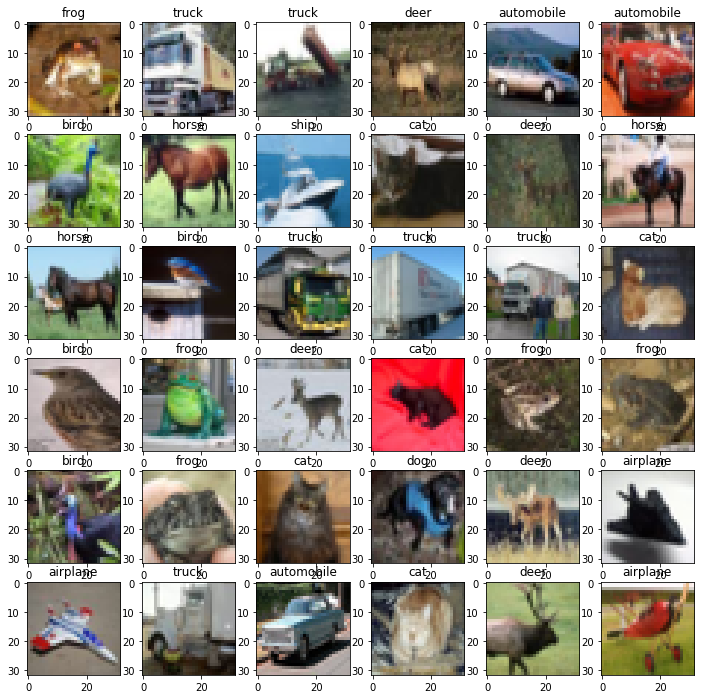

In [252]:
plt.figure(figsize=[12,12])
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(trainset.data[i], )
    plt.title(trainset.classes[trainset.targets[i]])

Display the distribution of images per label.

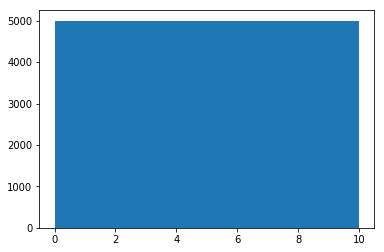

In [253]:
plt.hist(trainset.targets, [0,1,2,3,4,5,6,7,8,9,10]);

Is the data balanced? What effect is imbalanced data expected to have on your model's results? How can you work with imbalanced data?

* We see that the data is balanced: each one of the 10 classes has an equal amount of samples (5000) in the training set.
* Imbalanced data would skew the net towards a more frequent class, simply because it would recieve more samples of it.
* ***How can you work with imbalanced data?***


By subsampling over-presented classes or generating more smaples (by augmentation or just duplication) for under-presented classes 

**NOTE:** It's a good practice when working on Neural Networks to start with a very small dataset and overfit on it. 
While we don't specifically ask you to do so in the sections below, we recommend that you take this approach, 
and first write and run your code using easy to use and debug platform, on a small dataset.


## Build your own CNN classifier
In this section, you will develop your own CNN classifier.

This is meant as an opportunity to get more experience building your own NN architectures using PyTorch, and our focus is on making sure you rewrite and review the needed code and not on obtaining optimal performance. That being said, within the limits of the time you have, try to come up with a NN architecture and hyperparameters that would achieve nice results on the dataset.  
We do recommend that you keep this to only 3-4 Conv layers and 1-2 fully connected layers.

If you want a starting point, you can create this network:

```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

In [283]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flat_dim = 64 * 4 * 4
        self.fc1 = nn.Linear(self.flat_dim, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32x3 -> 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x16x16 -> 32x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 32x8x8x -> 64x8x8 -> 64x4x4
        x = x.view(-1, self.flat_dim)  # 64x4x4 -> 1024
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # 1024 -> 500
        x = self.dropout(x)
        x = self.fc2(x)  # 500 -> 10
        return F.softmax(input=x, dim=1)


cnn = CNN()
print(cnn)


CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


When training the network, use the Adam optimizer.

In [286]:
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [ ]:
def test_data_recorder(i, pred, writer, target, data, output, epoch):
    global step
    labels_dict = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog',
                   7: 'horse', 8: 'ship', 9: 'truck'}
    
    # Undo normalization to show the images on Tensorboard
    denormalize = transforms.Normalize((-1,), (1 / 0.5,))
    
    # Show some misclassified images in Tensorboard
    if i < 10 and target.data[pred != target.data].nelement() > 0:
        for inx, d in enumerate(data[pred != target.data]):
            img_name = 'Test-misclassified/Prediction-{}/Label-{}_Epoch-{}_{}/'.format(
                labels_dict[pred[pred != target.data].tolist()[inx]],
                labels_dict[target.data[pred != target.data].tolist()[inx]], epoch, i)
            writer.add_image(img_name, denormalize(d), epoch)
            i += 1

    # Record histograms:
    # Randomly pick batches to record (test dataset size = 10000, batch size 32)
    if epoch == 0 and random.randint(1, 100) < 4 or epoch > 0 and \
            random.randint(1, 100) < 2 or epoch == 0 and i < 2:
        
        image_max, label_conf = [[], [[] for x in range(32)]]    
        for t in range(output.size(0)):  # go over all tensors
            prob_out = F.softmax(output[t], dim=0)
            image_max.append(prob_out.max().item())
            for l in range(output.size(1)):  # go over all labels
                label_conf[l].append(prob_out[l].item())
        
        writer.add_histogram('Max confidence per image', np.array(image_max), step, bins='auto')
        for l in range(output.size(1)):
            writer.add_histogram('Confidence per label, label {}'.format(labels_dict[l]),
                                 np.array(label_conf[l]), step)
        writer.flush()
        step += 1
        print('.', end='')


In [287]:
def train(model, device, train_loader, opt, epoch, writer):
    model.train()

    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = model(data)
        loss = criterion(preds, target)
        loss.backward()
        opt.step()

        if batch_id % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_id * len(data), len(train_loader.dataset),
                       100. * batch_id / len(train_loader), loss.item()))
    # Record loss into the writer
    writer.add_scalar('Train/Loss', loss.item(), epoch)
    writer.flush()

In [288]:
def test(model, device, test_loader, epoch, writer):
    model.eval() # SWITCH TO TEST MODE
    i, test_loss, correct, n = [0, 0, 0, 0]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data).cpu().sum()
            
            # Record images and data into the writer:
            test_data_recorder(i, pred, writer, target, data, output, epoch)
            
    test_loss /= len(test_loader)  # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    # Record loss and accuracy into the writer
    writer.add_scalar('Test/Loss', test_loss, epoch)
    writer.add_scalar('Test/Accuracy', accuracy, epoch)
    writer.flush()

In [ ]:
time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()
step = 0

In [289]:
for epoch in range(0, 10):
    print("Epoch %d" % epoch)

    train(cnn, device, trainloader, optimizer, epoch, writer)
    test(cnn, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")

Tensorboard is recording into folder: .tb_logs/20200322_191716


In [ ]:
torch.save(cnn.state_dict(), '3_layers_conv_no_batch.pt')

Epoch 0
Train Epoch: 0 [0/50000 (0%)]	Loss: 1.588967
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.553656
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.615650
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.570162
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.667447
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.615579
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.606870
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.639832
....
Test set: Average loss: 1.7003, Accuracy: 7608/10000 (76%)

Epoch 1
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.581972
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.597170
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.563704
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.635518
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.560839
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.564230
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.571935
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.631304
..
Test set: Average loss: 1.6964, Accuracy: 7646/10000 (76%)

Epoch 2
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.588623
Train Epoch: 2 

## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

![Scalars](./images/scalars.png "20200324_161349-Scalars")

![Histogram](./images/histogram.png "20200324_161349-Histograms")

### Show images using TensorBoard

In [ ]:
![Pictures](./images/pictures.png "20200324_161349-Pictures")

### Inspect the model graph
You can print a network object to find useful information about it:

In [ ]:
print(cnn)

TensorBoard can help visualize the network graph. It takes practice to read these.  

Write the graph to TensorBoard and review it.

You can also use the package `torchsummary` for a fuller info on the model:

In [ ]:
!pip install torchsummary

In [ ]:
channels=3; H=32; W=32
from torchsummary import summary
summary(cnn, input_size=(channels, H, W))

## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer
1. Histogram of weights in the first layer

In [ ]:
# Done above

### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

In [ ]:
# TBD:


### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show 12 images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

In [ ]:
# Done above

## Batch Normalization
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flat_dim = 64 * 4 * 4
        self.batch_norm = nn.BatchNorm1d(self.flat_dim)
        self.fc1 = nn.Linear(self.flat_dim, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32x3 -> 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x16x16 -> 32x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 32x8x8x -> 64x8x8 -> 64x4x4
        x = self.batch_norm(x.view(-1, self.flat_dim))  # 64x4x4 -> 1024
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # 1024 -> 500
        x = self.dropout(x)
        x = self.fc2(x)  # 500 -> 10
        return F.softmax(input=x, dim=1)


cnn = CNN()
print(cnn)


Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

In [ ]:
time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()

step = 0

optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 30):
    print("Epoch %d" % epoch)

    train(cnn, device, trainloader, optimizer, epoch, writer)
    test(cnn, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")



#### Metrics with batch normalization 

![Scalars](./images/batch_norm_scalars.png "20200324_165630-Scalars")

![Histogram](./images/batch_norm_histograms.png "20200324_165630-Histograms")

## Data Augmentation
Augmenting the data is a useful trick to increase the size of the training set and reduce the generalization error.  

Useful resources: 
- [Explanation about augmentation](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)
- The [torchvision transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The [albumentations](https://github.com/albumentations-team/albumentations) repo

Try to think which transformation can be useful for data augmentation for our task?

In [ ]:
# TBD

Apply 1 or 2 basic transformations and check how they affect the network's performance:

In [ ]:
# Transformation used
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#### Compare Networks 
1. without batch normalization
2. with batch normalization 
3. with batch normalization and augmentation

![Histogram](./images/compare_not_norm_normlized_and_transformers.png "20200324_165630-Histograms")

## Transfer learning using a NN pre-trained on ImageNet
In this section, we will use a pretrained network and build a classifier using it to predict the labels of our task.

You might find these resources useful:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72

### Use a frozen pre-trained network
Use a VGG-16 network, including its weights pretrained on ImageNet.  
Use the pretrained network to obtain the distributed representation in the final layer (the one before the output softmax layer). Freeze the network weights, and add 2 fully connected layers on top of it to classify the images.

### Fine tuning the weights
In this section, we'll unfreeze the pre-trained weights of the network and allow them to change.  
Be careful - when fine-tuning a network, there is a risk that our attempt to allow the network to adapt to the new domain will lead to a "catastrophic forgetting" of what it had previously learnt.

## Suggested Resources
1. A good explanation of the different losses - https://gombru.github.io/2019/04/03/ranking_loss/
1. A repo with code implementing CNN classifiers, Siamese networks and Triplet loss with different selection regimes for the MNIST and Fashion-MNIST datasets - https://github.com/adambielski/siamese-triplet
1. There are several resources online for the VGG-Face network (see https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf), that include pre-trained weights on a face recognition dataset. The weights are here - http://www.robots.ox.ac.uk/~vgg/software/vgg_face/, and PyTorch models are here - http://www.robots.ox.ac.uk/~albanie/pytorch-models.html, and you can also check out https://github.com/prlz77/vgg-face.pytorch and https://github.com/claudio-unipv/vggface-pytorch.